In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, ward
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_samples
from matplotlib import cm

In [49]:
flats = pd.read_csv('~/Documents/kaggle/train.csv')
flats_test = pd.read_csv('~/Documents/kaggle/test.csv')
sub = pd.read_csv('~/Documents/kaggle/sample_submission.csv')

In [50]:
full = pd.concat([flats,flats_test], axis=0)

/home/samo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


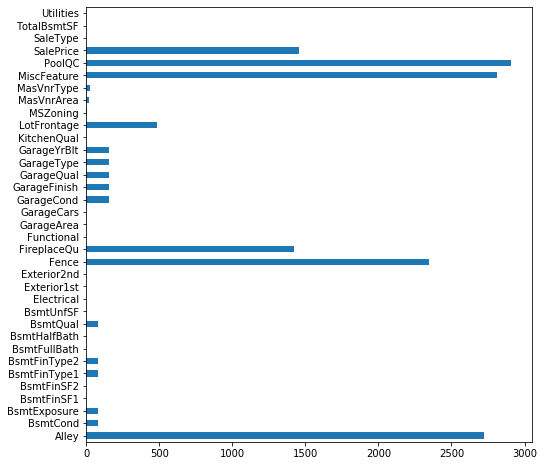

In [51]:
full_null = full.isna().sum()
plt.figure(figsize=(8,8))
full_null[full_null!=0].plot(kind='barh')

# Дропаем все фичи с большим количеством нанов

In [52]:
full_pre = full.copy()

In [53]:
full_pre.drop(['Id','Alley','PoolQC','Fence','MiscFeature'],axis=1, inplace=True)

In [54]:
num_features = full_pre.select_dtypes(exclude=['object']).columns 
full_pre[num_features] = full_pre[num_features].fillna(full[num_features].median())

In [55]:
cat_features = full_pre.select_dtypes(include=['object']).columns
#full_pre[cat_features] = full_pre[cat_features].fillna('No')

cat_features 
for cat in cat_features:
    full_pre[cat] = full_pre[cat].fillna(full_pre[cat].mode()[0])

In [56]:
full_pre.isna().any().any()

False

# Кодирование категориальных переменных 

In [57]:
from category_encoders import TargetEncoder
for cat in cat_features:
    encoder = TargetEncoder()
    full_pre[cat] = encoder.fit_transform(full_pre[cat], full_pre['SalePrice'])

# Логорифмирование числовых переменных со сдвигом


In [58]:
num_features = full_pre.select_dtypes(exclude=['object']).columns 
from scipy.stats import skew 
skewness = full_pre[num_features].apply(lambda x: skew(x))
skewness.sort_values(ascending=False)

skewness = skewness[abs(skewness)>0.5]

skew_features = full_pre[skewness.index]

In [59]:
full_pre[skew_features.columns] = np.log1p(full_pre[skew_features.columns])
full_pre[skew_features.columns]

,1stFlrSF,2ndFlrSF,3SsnPorch,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,SaleCondition,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt
0,6.753438,6.751101,0.0,12.069412,12.056845,12.002855,6.561031,0.0,12.199317,12.059969,...,12.038168,12.247699,12.033018,0.0,12.055653,2.197225,6.753438,12.055113,0.000000,7.602900
1,7.141245,0.000000,0.0,12.069412,12.056845,12.249963,6.886532,0.0,11.997012,12.059969,...,12.038168,12.109016,12.033018,0.0,12.055653,1.945910,7.141245,12.055113,5.700444,7.589336
2,6.825460,6.765039,0.0,12.069412,12.056845,12.085092,6.188264,0.0,12.199317,12.059969,...,12.038168,12.317171,12.033018,0.0,12.055653,1.945910,6.825460,12.055113,0.000000,7.601902
3,6.869014,6.629363,0.0,12.069412,12.154569,12.002855,5.379897,0.0,11.997012,12.059969,...,11.946292,11.849405,12.033018,0.0,12.055653,2.079442,6.629363,12.055113,0.000000,7.557995
4,7.044033,6.960348,0.0,12.069412,12.056845,12.133908,6.486161,0.0,12.199317,12.059969,...,12.038168,12.429220,12.033018,0.0,12.055653,2.302585,7.044033,12.055113,5.262690,7.601402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,6.304449,6.304449,0.0,11.924158,12.056845,12.002855,0.000000,0.0,12.009243,12.059969,...,12.038168,12.001512,12.033018,0.0,12.055653,1.791759,6.304449,12.055113,0.000000,7.586296
1455,6.304449,6.304449,0.0,12.058283,12.056845,12.002855,5.533389,0.0,11.954793,12.059969,...,11.946292,12.001512,12.033018,0.0,12.055653,1.945910,6.304449,12.055113,0.000000,7.586296
1456,7.110696,0.000000,0.0,12.069412,12.056845,12.002855,7.110696,0.0,11.997012,12.059969,...,11.946292,12.001512,12.033018,0.0,12.055653,2.079442,7.110696,12.055113,6.163315,7.581210
1457,6.878326,0.000000,0.0,12.069412,12.056845,12.133908,5.823046,0.0,12.199317,12.059969,...,12.038168,12.001512,12.033018,0.0,12.055653,1.945910,6.816736,12.055113,4.394449,7.597396


In [60]:
full_pre.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,6.753438,6.751101,0.0,3,12.069412,12.056845,12.002855,6.561031,0.0,12.199317,...,12.033018,0.0,12.055653,2.197225,6.753438,12.055113,0.000000,7.602900,2003,2008
1,7.141245,0.000000,0.0,3,12.069412,12.056845,12.249963,6.886532,0.0,11.997012,...,12.033018,0.0,12.055653,1.945910,7.141245,12.055113,5.700444,7.589336,1976,2007
2,6.825460,6.765039,0.0,3,12.069412,12.056845,12.085092,6.188264,0.0,12.199317,...,12.033018,0.0,12.055653,1.945910,6.825460,12.055113,0.000000,7.601902,2002,2008
3,6.869014,6.629363,0.0,3,12.069412,12.154569,12.002855,5.379897,0.0,11.997012,...,12.033018,0.0,12.055653,2.079442,6.629363,12.055113,0.000000,7.557995,1970,2006
4,7.044033,6.960348,0.0,4,12.069412,12.056845,12.133908,6.486161,0.0,12.199317,...,12.033018,0.0,12.055653,2.302585,7.044033,12.055113,5.262690,7.601402,2000,2008


In [62]:
full_pre = pd.get_dummies(full_pre,drop_first=False)

In [63]:
full_pre.isna().any().any()

False

# Обучение

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor

In [65]:
y = full_pre['SalePrice'].iloc[0:1460]

In [66]:
full_pre = full_pre.drop(['SalePrice'],axis = 1)

train = full_pre.iloc[0:1460]
test = full_pre.iloc[1460:]

In [67]:
scoring='neg_mean_squared_error'
x_train,x_test,y_train,y_test = train_test_split(train,y.to_numpy(),random_state= 42)

In [68]:
lr = LinearRegression()
lr.fit(x_train,y_train)

train_pre = (lr.predict(x_train))
test_pre = (lr.predict(x_test))

print("train MSE:", mean_squared_error(train_pre, y_train))
print("test MSE:", mean_squared_error(test_pre, y_test))

train MSE: 0.013244249345024777
test MSE: 0.016722986198198272


In [69]:
rcv = RidgeCV()

rcv.fit(x_train, y_train)

train_pre = ((rcv.predict(x_train)))
test_pre = ((rcv.predict(x_test)))

print("train MSE:", mean_squared_error(train_pre, y_train))
print("test MSE:", mean_squared_error(test_pre, y_test))

train MSE: 0.01389257588689582
test MSE: 0.015491697659511163


In [70]:
gbr = GradientBoostingRegressor(max_depth=2, learning_rate = 0.1, n_estimators=200)
gbr.fit(x_train, y_train)

train_pre = gbr.predict(x_train)
test_pre = gbr.predict(x_test)

print("train MSE:", mean_squared_error(train_pre, y_train))
print("test MSE:", mean_squared_error(test_pre, y_test))

train MSE: 0.006759778347792392
test MSE: 0.015619201304881997


In [71]:
import catboost
from catboost import CatBoostRegressor

In [72]:
cat = CatBoostRegressor(depth=2, learning_rate = .1, iterations=200, silent = True)
cat.fit(x_train, y_train)

train_pre = cat.predict(x_train)
test_pre = cat.predict(x_test)

print("train MSE:", mean_squared_error(train_pre, y_train))
print("test MSE:", mean_squared_error(test_pre, y_test))

train MSE: 0.01014569735282376
test MSE: 0.015723071566220357


In [73]:
def blend(x):
    return (0.3 * cat.predict(x)) + (0.3 * gbr.predict(x)) + (0.3 * rcv.predict(x)) + (0.1 * lr.predict(x))
pred1 = blend(x_test)
print("test MSE:", mean_squared_error(pred1, y_test))

test MSE: 0.014307555853502171


In [74]:
final_test_pre = blend(test)

normal_prices_arr = np.expm1(final_test_pre)
n_prices_df = pd.DataFrame(normal_prices_arr.tolist(), columns=['SalePrice'], index=range(1461, 2920)).rename_axis('Id')

In [75]:
n_prices_df.to_csv('submission8.csv')